In [1]:
import os
import numpy as np
import pandas as pd



# 모델 수 및 클라이언트 수
M = 53  # 모델 수 (src_001~src_053)
J = 53  # 클라이언트 수 (tgt_001~tgt_053)

# 경로 설정 (파일들이 저장된 디렉토리)
dir_path = "./raw/"  # 파일이 업로드된 디렉토리 경로

# probs, labels 초기화
probs = {i: {} for i in range(1, M+1)}  # probs[i][j] -> 확률 값
labels = {j: [] for j in range(1, J+1)}  # labels[j] -> 라벨 값

# CSV 파일 로드 및 전처리
for i in range(1, M+1):  # 모델 번호
    for j in range(1, J+1):  # 클라이언트 번호
        file_path = os.path.join(dir_path, f"src_{str(i).zfill(3)}/probs/tgt_{str(j).zfill(3)}.csv")
        
        # 각 파일이 존재하면 읽기
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            
            # 확률(p_A)과 라벨(label_num) 추출
            probs[i][j] = df['p_A'].values  # 모델 i의 클라이언트 j에 대한 p(A) 확률
            labels[j] = df['label_num'].values  # 클라이언트 j에 대한 라벨
            
        else:
            print(f"Warning: File {file_path} not found!")

# 데이터 확인
print(probs[1][1][:5])  # 첫 번째 모델과 첫 번째 클라이언트에 대한 확률 예시
print(labels[1][:5])  # 첫 번째 클라이언트에 대한 라벨 예시

[0.32082132 0.21206881 0.63703084 0.30735803 0.59266663]
[0 0 0 0 1]


In [2]:
print(probs)
print(labels)

{1: {1: array([0.32082132, 0.21206881, 0.63703084, 0.30735803, 0.59266663,
       0.2814056 , 0.76629364, 0.62245935, 0.65135491, 0.7879312 ,
       0.54673815, 0.54673815, 0.51561993, 0.5       , 0.79818678,
       0.74316794, 0.86703575, 0.45326188, 0.71859437, 0.79818678,
       0.40733343, 0.67917871, 0.5774954 , 0.45326188, 0.23370634,
       0.30735803, 0.11920292, 0.71859437, 0.73105854, 0.4378235 ,
       0.20181322, 0.56217653, 0.21206881, 0.46879065, 0.56217653,
       0.59266663, 0.65135491, 0.89330941, 0.256832  , 0.30735803]), 2: array([0.77729988, 0.54673815, 0.83548355, 0.53120941, 0.34864515,
       0.56217653, 0.65135491, 0.46879065, 0.5774954 , 0.66541058,
       0.37754068, 0.53120941, 0.33458945, 0.37754068, 0.73105854,
       0.30735803, 0.2814056 , 0.62245935, 0.51561993, 0.53120941,
       0.4843801 , 0.256832  , 0.42250463, 0.46879065, 0.79818678,
       0.8080672 , 0.63703084, 0.94334757, 0.66541058, 0.256832  ,
       0.51561993, 0.62245935, 0.754915  , 0.8175

In [3]:
import numpy as np

def dict_to_arrays(probs_dict, labels_dict):
    """
    probs_dict: dict[int]->dict[int]->1D np.array (n_items,)
    labels_dict: dict[int]->1D np.array (n_items,)
    returns:
        P: (n_models, n_clients, n_items)
        L: (n_clients, n_items)
        model_keys, client_keys: 리스트(원복용)
    """
    model_keys  = sorted(probs_dict.keys())         # [1..M]
    client_keys = sorted(labels_dict.keys())        # [1..J]
    n_models, n_clients = len(model_keys), len(client_keys)

    # 기준 item 길이
    n_items = int(np.asarray(labels_dict[client_keys[0]]).shape[0])

    # L 쌓기
    L = np.stack([np.asarray(labels_dict[j], dtype=float) for j in client_keys], axis=0)
    assert L.shape == (n_clients, n_items), "labels shape mismatch"

    # P 쌓기
    P = np.zeros((n_models, n_clients, n_items), dtype=float)
    for mi, i in enumerate(model_keys):
        for cj, j in enumerate(client_keys):
            assert j in probs_dict[i], f"probs[{i}][{j}] missing"
            v = np.asarray(probs_dict[i][j], dtype=float)
            assert v.ndim == 1 and v.shape[0] == n_items, f"probs[{i}][{j}] length mismatch"
            P[mi, cj, :] = v

    return P, L, model_keys, client_keys



# 1) dict -> ndarray로 변환
P, L, model_keys, client_keys = dict_to_arrays(probs, labels)

In [8]:
print(P.shape)
print(P)

(53, 53, 40)
[[[0.32082132 0.21206881 0.63703084 ... 0.89330941 0.256832   0.30735803]
  [0.77729988 0.54673815 0.83548355 ... 0.5774954  0.67917871 0.46879065]
  [0.32082132 0.40733343 0.83548355 ... 0.32082132 0.51561993 0.14033625]
  ...
  [0.32082132 0.5        0.40733343 ... 0.37754068 0.73105854 0.46879065]
  [0.30735803 0.70578504 0.85966372 ... 0.36296922 0.37754068 0.63703084]
  [0.59266663 0.70578504 0.56217653 ... 0.62245935 0.65135491 0.40733343]]

 [[0.36296922 0.33458945 0.32082132 ... 0.42250463 0.33458945 0.33458945]
  [0.37754068 0.39233685 0.32082132 ... 0.59266663 0.56217653 0.5       ]
  [0.2814056  0.34864515 0.39233685 ... 0.54673815 0.56217653 0.42250463]
  ...
  [0.5        0.46879065 0.40733343 ... 0.26894143 0.4378235  0.4378235 ]
  [0.4843801  0.4378235  0.45326188 ... 0.4843801  0.5        0.40733343]
  [0.4843801  0.40733343 0.42250463 ... 0.30735803 0.37754068 0.4378235 ]]

 [[0.45326188 0.45326188 0.51561993 ... 0.4843801  0.42250463 0.45326188]
  [0.4843

In [10]:
import numpy as np

def entropy_per_col_from_P(P: np.ndarray):
    assert P.shape == (53, 53, 40), f"unexpected shape: {P.shape}"
    # 1) (53, 2120)으로 펴기
    X = P.reshape(53, -1)

    # 2) 임계치 이진화 (>= 0.5 → 1, else 0), float64 유지
    B = (X >= 0.5).astype(np.float64)

    # 3) 각 column별 pi = (True의 개수) / 53
    pi = B.mean(axis=0, dtype=np.float64)  # shape: (2120,)

    # 4) 엔트로피 H(pi) = -(pi log pi + (1-pi) log(1-pi))
    #    p=0 또는 1에서 log(0)을 피하기 위해 clip
    p = np.clip(pi, np.finfo(np.float64).tiny, 1 - np.finfo(np.float64).tiny)
    H = -(p * np.log(p) + (1 - p) * np.log(1 - p))  # nats

    # 필요하면 bits로: H_bits = H / np.log(2)
    return H.tolist()  # 2120개 float 리스트

# 사용 예:
H_list = entropy_per_col_from_P(P)
len(H_list) == 2120


print(H_list)


[0.31246477985873944, 0.16068056204154624, 0.577354049143257, 0.3531693834437995, 0.684399679283535, 0.31246477985873944, 0.6929691707091894, 0.6886905739680003, 0.6124545112186726, 0.3124647798587394, 0.6714519120090439, 0.5349082431307516, 0.6714519120090439, 0.684399679283535, 0.6915443304085231, 0.5106886688599794, 0.6786591340630184, 0.684399679283535, 0.5773540491432572, 0.6929691707091894, 0.6124545112186726, 0.6886905739680003, 0.6124545112186726, 0.6915443304085231, 0.6929691707091894, 0.6786591340630184, 0.48430217949997767, 0.5349082431307516, 0.6627561588450714, 0.6786591340630184, 0.5570934265416042, 0.684399679283535, 0.16068056204154624, 0.6714519120090439, 0.4843021794999776, 0.6929691707091894, 0.684399679283535, 0.5106886688599794, 0.217518571336808, 0.09359996324581574, 0.6274370336771098, 0.6714519120090439, 0.6786591340630184, 0.6714519120090439, 0.4243420197199883, 0.684399679283535, 0.5773540491432572, 0.6786591340630184, 0.6886905739680003, 0.6627561588450714, 0

/home/seongyoon/anaconda3/envs/fedfn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/home/seongyoon/anaconda3/envs/fedfn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


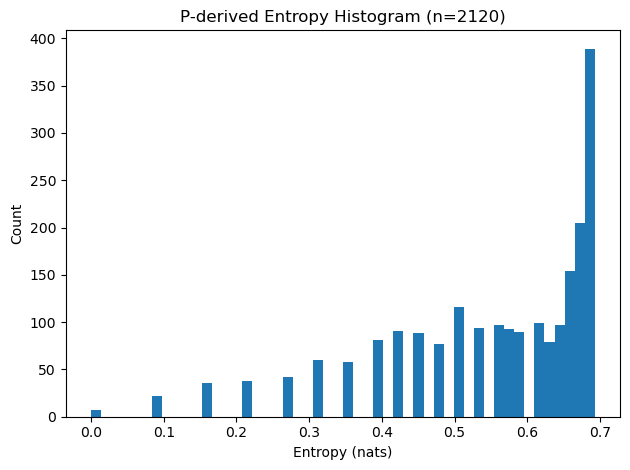

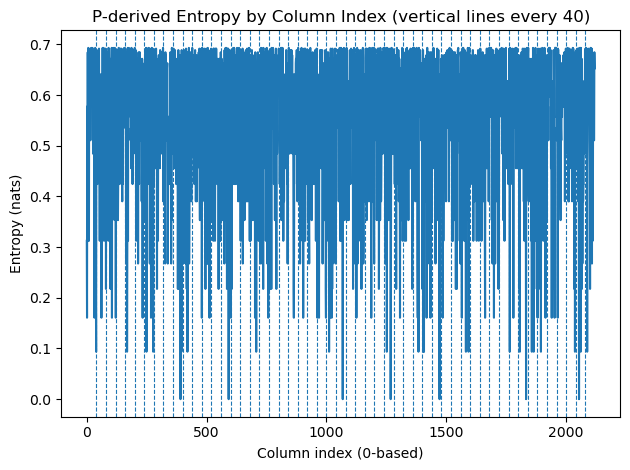

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# ========= ① 히스토그램 + 40개 단위 경계선 =========
def plot_entropy_hist_and_blocks(H, block_size=40, bins=50, title_prefix="Entropy"):
    H = np.asarray(H, dtype=np.float64)
    assert H.ndim == 1 and H.size % block_size == 0, "H 길이는 block_size의 배수여야 합니다."

    # (A) 히스토그램
    plt.figure()
    plt.hist(H, bins=bins)
    plt.title(f"{title_prefix} Histogram (n={H.size})")
    plt.xlabel("Entropy (nats)")
    plt.ylabel("Count")
    plt.tight_layout()

    # (B) 인덱스별 값 + 40개 단위 경계선
    plt.figure()
    x = np.arange(H.size)
    plt.plot(x, H)
    # 40, 80, 120, ... 위치에 경계선
    for v in range(block_size, H.size, block_size):
        plt.axvline(v, linestyle="--", linewidth=0.8)
    plt.title(f"{title_prefix} by Column Index (vertical lines every {block_size})")
    plt.xlabel("Column index (0-based)")
    plt.ylabel("Entropy (nats)")
    plt.tight_layout()

# ========= ② P -> H(엔트로피 리스트) 변환 =========
def entropy_per_col_from_P(P):
    assert P.shape == (53, 53, 40), f"unexpected shape: {P.shape}"
    X = P.reshape(53, -1)                              # (53, 2120)
    B = (X >= 0.5).astype(np.float64)                  # 이진화
    pi = B.mean(axis=0, dtype=np.float64)              # (2120,)
    p = np.clip(pi, np.finfo(np.float64).tiny, 1 - np.finfo(np.float64).tiny)
    H = -(p * np.log(p) + (1 - p) * np.log(1 - p))     # nats
    return H

# 사용 예:

plot_entropy_hist_and_blocks(H_list, block_size=40, bins=50, title_prefix="P-derived Entropy")


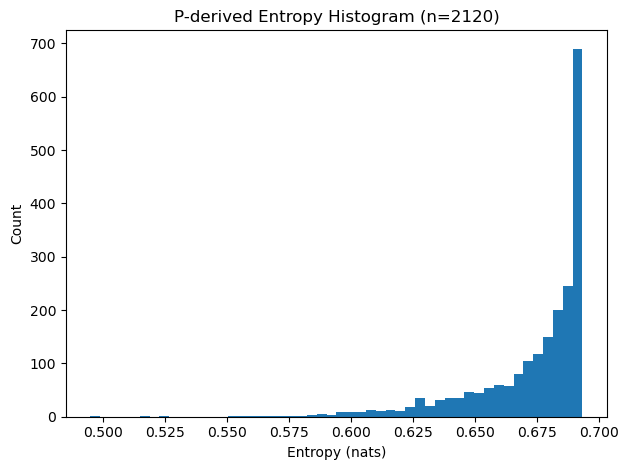

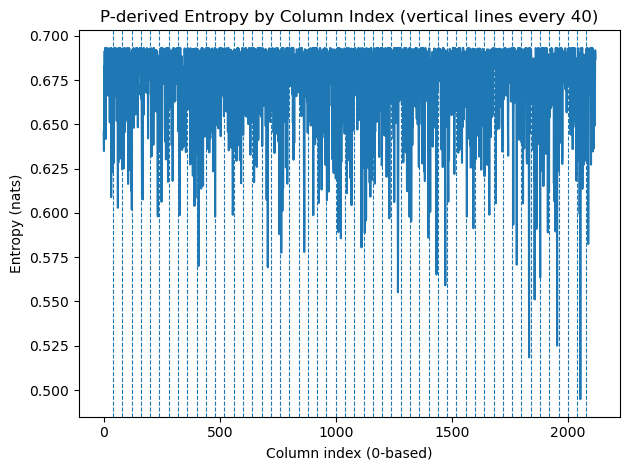

In [12]:
import numpy as np

def entropy_from_empirical_mean(P: np.ndarray):
    """
    P: shape (53, 53, 40), 값 범위 [0,1] 가정
    1) (53, 2120)으로 펼친 뒤 각 column의 단순 평균을 pi로 잡음
    2) H(pi) = -(pi log pi + (1-pi) log(1-pi)) (nats) 반환
    반환: (H, pi)
      - H: shape (2120,)  각 컬럼의 엔트로피 (float64, nats)
      - pi: shape (2120,) 각 컬럼의 empirical mean (float64)
    """
    assert P.shape == (53, 53, 40), f"unexpected shape: {P.shape}"

    # (53, 2120)으로 reshape
    X = P.reshape(53, -1).astype(np.float64)  # (53, 2120)

    # 이진화 없이 단순 평균
    pi = X.mean(axis=0, dtype=np.float64)     # (2120,)

    # 수치 안정화를 위해 clip (0 또는 1인 경우 log(0) 방지)
    eps = np.finfo(np.float64).tiny
    p = np.clip(pi, eps, 1 - eps)

    # Bernoulli entropy (nats)
    H = -(p * np.log(p) + (1 - p) * np.log(1 - p))

    return H, pi

# 사용 예:
H, pi = entropy_from_empirical_mean(P)

plot_entropy_hist_and_blocks(H, block_size=40, bins=50, title_prefix="P-derived Entropy")